<a href="https://colab.research.google.com/github/sanislearning/ml_playground/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


In [3]:
drive.mount("/content/drive")
file_path='/content/drive/MyDrive/PData/mnist/train-images.idx3-ubyte'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import struct #helps interpret bytes as packed binary data, lets us read IDX file format
with open(file_path,'rb') as f: #rb means read binary
  #Read the magic number and dimensions
  magic,num_images,rows,cols=struct.unpack('>IIII',f.read(16))
  #f.read(16) means that you read first 16 bytes, ie header of IDX file, ie metadata of file
  #struct.unpack('>IIII',...) interprets those 16 bytes as 4 big-endian unsigned integers
  # > =  Big endian (most significant byte first)

  print("Magic Number: ",magic)
  print("Number of Images: ",num_images)
  print("Image Size: ",rows,"x",cols)
  image_bytes=f.read(rows*cols)  #reads only the first image
  image=np.frombuffer(image_bytes,dtype=np.uint8).reshape((rows,cols))
  #converts the bytes into a NumPy array and then reshapes it into a 2D array of shape

Magic Number:  2051
Number of Images:  60000
Image Size:  28 x 28


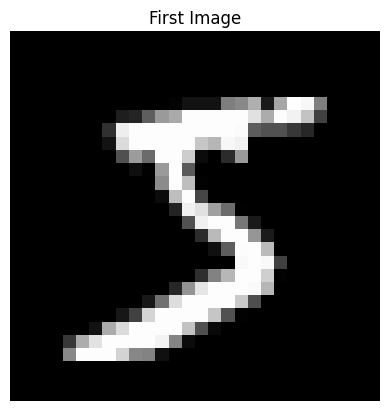

In [5]:
#Visualizing the Image
plt.imshow(image,cmap='gray')
plt.title("First Image")
plt.axis('off')
plt.show()

In [6]:
with open(file_path,'rb') as f: #read binary format
  f.read(16) #skips the header
  image_data=f.read(num_images*rows*cols)

images=np.frombuffer(image_data,dtype=np.uint8) #converts the raw bytes into a NumPy array, interpret each byte as an unsigned 8-bit integer
images=images.reshape((num_images,rows,cols)) #It's a 3D array. It has 60000 images, each 28th rows high and 28 columns wide

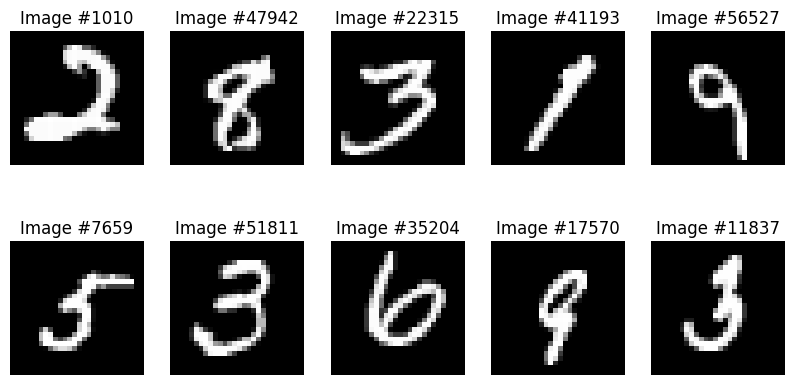

In [7]:
import random

plt.figure(figsize=(10, 5))
for i in range(10):
    idx = random.randint(0, 59999)
    plt.subplot(2, 5, i+1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(f"Image #{idx}")
    plt.axis('off')
plt.show()

In [8]:
images=images/255.0

#Load the Labels

In [9]:
label_file_path='/content/drive/MyDrive/PData/mnist/train-labels.idx1-ubyte'

with open(label_file_path,'rb') as f:
  magic,num_labels=struct.unpack('>II',f.read(8))
  print("Magic Number: ",magic)
  print("Number of Labels: ",num_labels)

  #Read the rest of the file - each label is 1 byte
  label_bytes=f.read(num_labels)
  #Convert to a NumPy array of unsigned 8-bit intergers
  labels=np.frombuffer(label_bytes,dtype=np.uint8)

Magic Number:  2049
Number of Labels:  60000


In [10]:
x=images.reshape((num_images,28*28)) # each image becomes a 784-length vector

In [11]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x,labels,test_size=0.2,random_state=42)
#x_train,y_train is used for training
#x_val,y_val is used for validation/testing

#Training and Evaluation

In [12]:
from sklearn.metrics import accuracy_score,classification_report

In [13]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=1000)
model.fit(x_train,y_train)
y_pred=model.predict(x_val)

In [15]:
print(accuracy_score(y_val,y_pred))

0.9223333333333333


In [18]:
def objective(trail):
  C=trail.suggest.suggest_loguniform('C',1e-4,1e2)
  #inverse of regularization strength in logistic regression
  #suggest_loguniform lets Optuna try values between 1e-4 and 1e4 on a log scale
  solver=trail.suggest_categorical('solver',['liblinear','lbfgs','saga'])
  # solver is the algorithm used to train the model.
  # liblinear good for small datasets, supports L1
  # lbfgs good for L2 and multiclass
  # saga supports both L1 and L2 and works with large datasets
  penalty='l2' if solver !='liblinear' else trail.suggest_categorialcal('penalty',['l1','l2'])
  model=LogisticRegression(C=C,solver=solver,penalty=penalty,max_iter=1000)
  model.fit(x_train,y_train)
  y_pred=model.predict(x_val)
  accuracy=accuracy_score(y_val,y_pred)

  return accuracy